# PCA - Human Activity Recognition

En éste ejercicio vamos a usar datos provenientes de acelerómetros, giróscopos y otros sensores de smartphones Samsung Galaxy S3. A partir de esos sensores, se crearon distintas features (aceleración, jerk, ángulos, etc.) cuyo objetivo es permitir predecir distintos tipos de activididades que se etiquetaron en la experimentación. Para más información sobre los datos, consultar la fuente [original](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones).

### Importamos las librerías

<style>
  table {margin-left: 0 !important;}
</style>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 17

### Cargamos el dataset

In [2]:
PATH_DATASET = "./data/UCI HAR Dataset/train"

In [3]:
X_train = np.loadtxt(os.path.join(PATH_DATASET, "X_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_DATASET, "y_train.txt")).astype(int)

### EDA Mínimo

In [4]:
print("Estructura features del dataset: {}".format(X_train.shape))
print("Estructura de las etiquetas: {}".format(y_train.shape))

Estructura features del dataset: (7352, 561)
Estructura de las etiquetas: (7352,)


In [5]:
# Exploramos un poco las features
df = pd.DataFrame(data=X_train)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


In [6]:
df.isna().sum().sum()

0

In [7]:
# Cantidad única de clases
clases = np.unique(y_train)
clases

array([1, 2, 3, 4, 5, 6])

In [8]:
n_clases = clases.size

In [9]:
n_clases

6

|     Label     |   Descripción  | 
| ------------- |:-------------: |
|       1       | Caminar        | 
|       2       | Subir escaleras|
|       3       | Bajar escaleras|
|       4       | Estar sentado  |
|       5       | Estar parado   |
|       6       | Recostarse     |

### Aplicamos PCA

In [89]:
# Estandarizamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

Al aplicar PCA, es una práctica común reducir el número de dimensiones, dejando tantos componentes como sean necesarios para que contemplen al menos el 90% de la varianza de los datos escalados originales. Scikit-learn permite indicar directamente ese parámetro como condición. Si no se puede seleccionar un número alto de componentes y mediante un scree plot, verificar cuántos son necesarios para mantener un 90%.

In [90]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [91]:
X_pca.shape

(7352, 63)

In [6]:
# Cantidad de componentes necesarios
X_pca.shape[1]

63

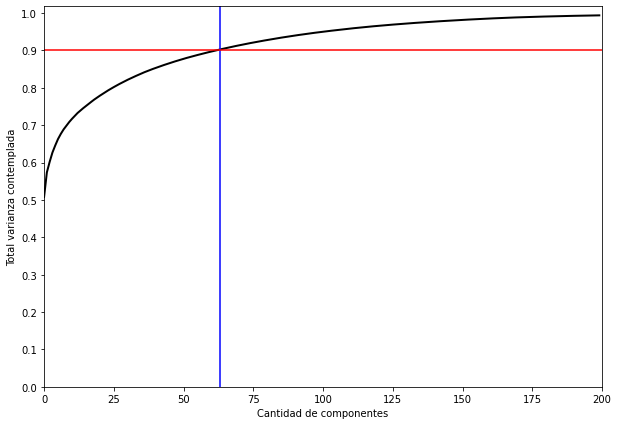

In [9]:
pca_2 = PCA(n_components=200, random_state=RANDOM_STATE).fit(X_scaled)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, 200)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(63, c='b')
plt.axhline(0.9, c='r')
plt.show();

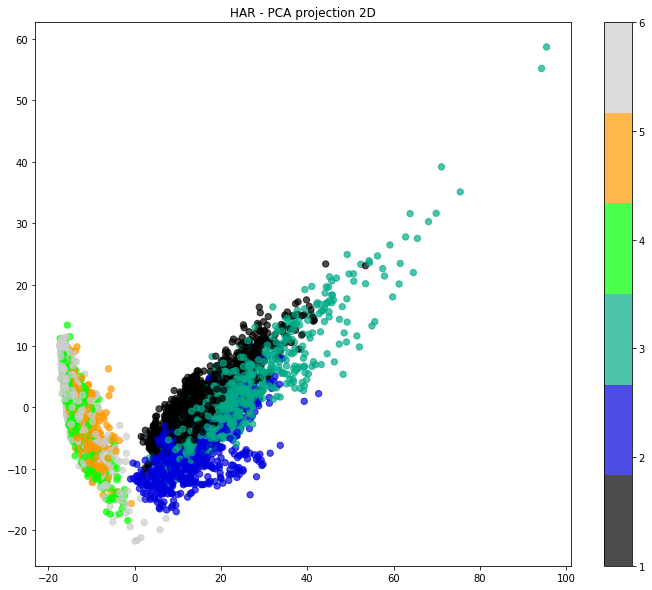

In [10]:
# Graficamos los primeros dos componentes
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.rcParams['axes.grid'] = False #Evita un warning
plt.colorbar()
plt.title('HAR - PCA projection 2D');

### Clusterización

![image](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png)

In [14]:
kmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

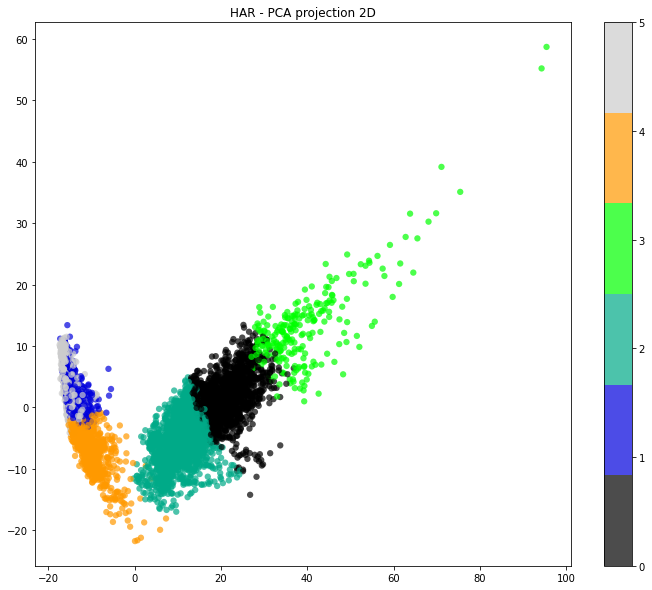

In [15]:
# Graficamos los primeros dos componentes - clusters id
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.rcParams['axes.grid'] = False
plt.colorbar()
plt.title('HAR - PCA projection 2D');

In [92]:
kmeans_move = KMeans(n_clusters=2, n_init=100, random_state=RANDOM_STATE)
kmeans_move.fit(X_pca)
cluster_labels_mov = kmeans_move.labels_

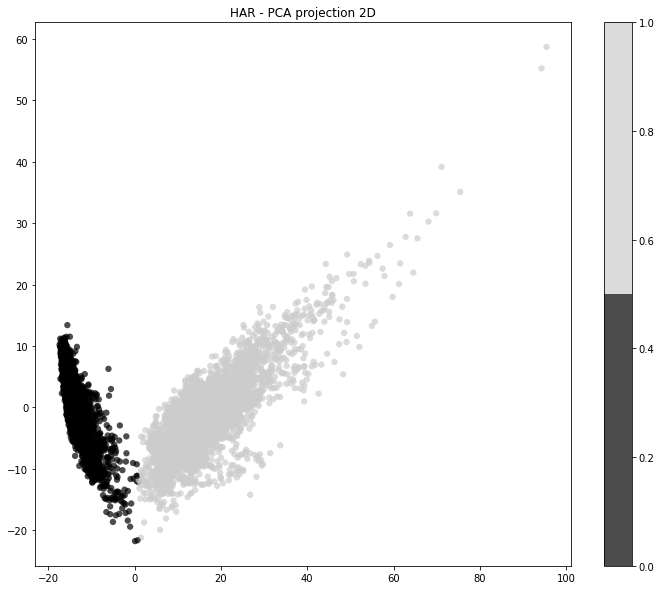

In [93]:
# Graficamos los primeros dos componentes - clusters id
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_mov, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 2))
plt.colorbar()
plt.title('HAR - PCA projection 2D');

In [19]:
tab = pd.crosstab(y_train, cluster_labels, margins=True)
tab.index = ['Caminar', 'Subir escaleras', 'Bajar escaleras', 'Estar parado', 'Estar sentado', 'Recostarse', 'Todos']
tab.columns = ['cluster ' + str(i + 0) for i in range(6)] + ['Todos']
tab

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,Todos
Caminar,512,0,646,68,0,0,1226
Subir escaleras,210,0,856,5,2,0,1073
Bajar escaleras,620,0,200,166,0,0,986
Estar parado,0,884,1,0,315,86,1286
Estar sentado,0,999,0,0,375,0,1374
Recostarse,0,26,4,0,270,1107,1407
Todos,1342,1909,1707,239,962,1193,7352


In [20]:
tab = pd.crosstab(y_train, cluster_labels_mov, margins=True)
tab.index = ['Caminar', 'Subir escaleras', 'Bajar escaleras', 'Estar parado', 'Estar sentado', 'Recostarse', 'Todos']
tab.columns = ['cluster ' + str(i + 0) for i in range(2)] + ['Todos']
tab

,cluster 0,cluster 1,Todos
Caminar,0,1226,1226
Subir escaleras,8,1065,1073
Bajar escaleras,0,986,986
Estar parado,1285,1,1286
Estar sentado,1374,0,1374
Recostarse,1396,11,1407
Todos,4063,3289,7352


### K-means - Inercia

In [21]:
# Vemos la inercia (suma de las distancias de los miembros de un cluster a su centroide)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

$$\Large J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

$C$ – es un set de clusters de orden $K$, $\mu_k$ es el centroide del cluster $C_k$.

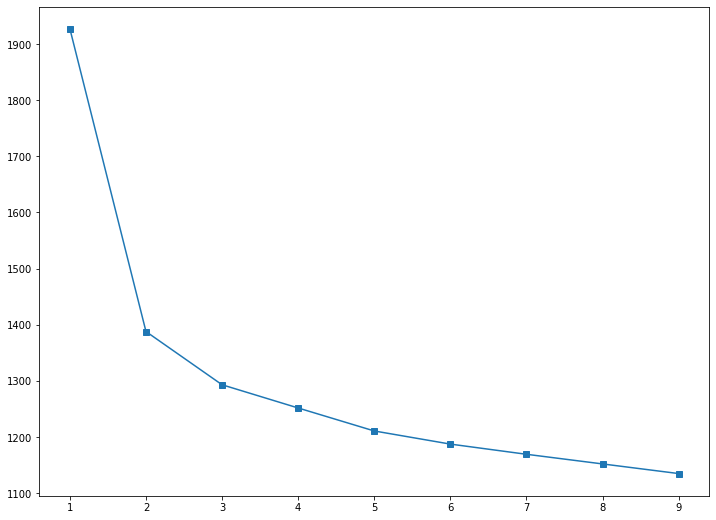

In [22]:
plt.plot(range(1, 10), inertia, marker='s')
plt.show()

Se quiere minimizar la Inercia, pero el óptimo está en K = N, por lo tanto se introduce la variable D, que mide las proporciones de diferencia de inercia entre K sucesivos. 

$$\Large D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

In [23]:
d = {}
for k in range(2, 9):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1])  / (inertia[i - 1] - inertia[i]) 

In [24]:
d

{2: 0.1757864806508066,
 3: 0.4362158045123339,
 4: 0.9898554475537894,
 5: 0.5714038657779513,
 6: 0.7758425214730489,
 7: 0.9471295517191429,
 8: 0.9983524839438216}

---

### Bibliografía

* [Performance Metrics in Machine Learning — Part 3: Clustering](https://towardsdatascience.com/performance-metrics-in-machine-learning-part-3-clustering-d69550662dc6)

* [Kaggle Notebook - 1](https://www.kaggle.com/kashnitsky/a7-demo-unsupervised-learning-solution?select=samsung_test_labels.txt)

* [Información sobre el dataset](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)